#Modeling Section

## Imports, Settings and reading dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
print(os.getcwd())

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/nidhicodes4045/datascience442/a5b906a9d039c38302197bdfb6f72d8581de15a2/Uwa_subset.csv")

In [ ]:
df.head()

,State,Low Access Numbers.People.10 Miles,Vehicle Access.10 Miles,Sales.Retail Sales,Income.Median Houseold Income,Region
0,al,5119,222.0000,607854.0000,58731,South
1,al,2308,32.0000,3145789.0000,58320,South
2,al,4643,201.0000,206477.0000,32525,South
3,al,365,0.0000,118871.0000,47542,South
4,al,0,0.0000,298745.0000,49358,South


## Analysis and Prediction

In [182]:
# Produces dummy variables for Region
df_dummy = pd.get_dummies(df, columns=['Region'], drop_first=True)

df_dummy.rename(columns={
    'Low Access Numbers.People.10 Miles': 'Low_Access_Numbers_10_Miles',
    'Vehicle Access.10 Miles': 'Vehicle_Access_10_Miles',
    'Sales.Retail Sales': 'Retail_Sales',
    'Income.Median Houseold Income': 'Median_Household_Income'
}, inplace=True)
df_dummy.head()

# Standardizes and applies a log tranformation for Low_Access_Numbers_10_Miles and Vehicle_Access_10_Miles
df_dummy["Low_Access_Numbers_10_Miles"] = (df_dummy["Low_Access_Numbers_10_Miles"] - df_dummy["Low_Access_Numbers_10_Miles"].mean()) / df_dummy["Low_Access_Numbers_10_Miles"].std()
df_dummy["Log_Low_Access_Numbers_10_Miles"] = np.log1p(df_dummy["Low_Access_Numbers_10_Miles"])
df_dummy["Vehicle_Access_10_Miles"] = (df_dummy["Vehicle_Access_10_Miles"] - df_dummy["Vehicle_Access_10_Miles"].mean()) / df_dummy["Vehicle_Access_10_Miles"].std()
df_dummy["Log_Vehicle_Access_10_Miles"] = np.log1p(df_dummy["Vehicle_Access_10_Miles"])
df_dummy.head()

,State,Low_Access_Numbers_10_Miles,Vehicle_Access_10_Miles,Retail_Sales,Median_Household_Income,Region_Northeast,Region_South,Region_West,Log_Low_Access_Numbers_10_Miles,Log_Vehicle_Access_10_Miles
0,al,1.4605,2.4798,607854.0000,58731,False,True,False,0.9004,1.2470
1,al,0.2823,0.0477,3145789.0000,58320,False,True,False,0.2486,0.0466
2,al,1.2610,2.2110,206477.0000,32525,False,True,False,0.8158,1.1666
3,al,-0.5321,-0.3619,118871.0000,47542,False,True,False,-0.7595,-0.4492
4,al,-0.6851,-0.3619,298745.0000,49358,False,True,False,-1.1555,-0.4492


I standardized then tranformed my the variables in my model because the previous values produced validations in my assumptions for linear regression.

In [183]:
# Selects features
features = ["Log_Vehicle_Access_10_Miles", "Region_Northeast", "Region_South", "Region_West"]
X = df_dummy[features].values
y = df_dummy["Log_Low_Access_Numbers_10_Miles"].values

In [184]:
import statsmodels.formula.api as smf

model = smf.wls(formula = 'Log_Low_Access_Numbers_10_Miles ~ Log_Vehicle_Access_10_Miles + Region_Northeast + Region_South + Region_West',
                data = df_dummy)
results = model.fit()
print(results.summary())

                                   WLS Regression Results                                  
Dep. Variable:     Log_Low_Access_Numbers_10_Miles   R-squared:                       0.584
Model:                                         WLS   Adj. R-squared:                  0.583
Method:                              Least Squares   F-statistic:                     1098.
Date:                             Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                                     01:17:57   Log-Likelihood:                -1980.1
No. Observations:                             3138   AIC:                             3970.
Df Residuals:                                 3133   BIC:                             4001.
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
                                  coef    std err          t      P>|t|      [0.

### Checking for Multiple Linear Regression Assumptions


*   Constant variance and Linearity
*   Normality among residuals
*   Independence of residuals





#### Checks for Linearity and Constant Variance

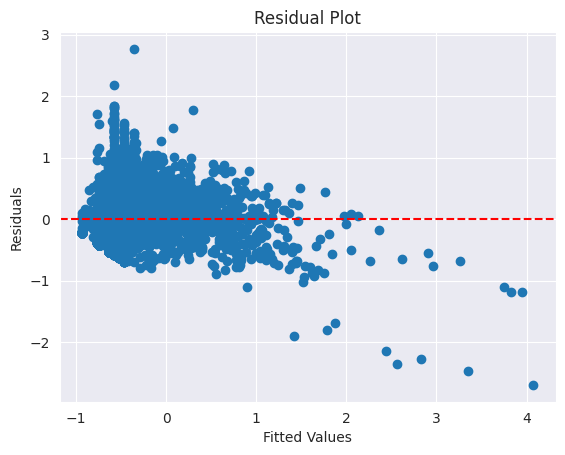

In [185]:
fitted_vals = results.fittedvalues
residuals = results.resid

plt.scatter(fitted_vals, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The residuals seem evenly distributed around the line, but the points seem to be following some kind of pattern which may suggest a violation in our linearity assumption. Proceed with caution.

#### Check for Independence Among Residuals

In [175]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals)

np.float64(1.9335370073186189)

Since the Durbin-Watson test produced a value 1.70, which is between 0 and 4. We can assume the residuals are independent.

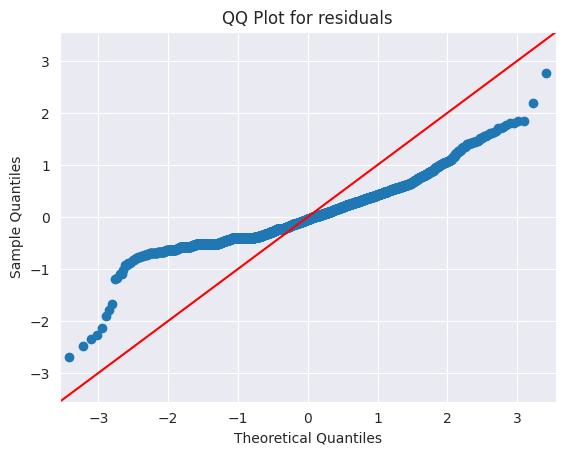

Jarque-Bera Test: stat=1007.651997900988, p=1.5529190458281283e-219


In [186]:
import statsmodels.api as sm

# Create QQ plot for residuals
sm.qqplot(residuals, line='45')
plt.title("QQ Plot for residuals")
plt.show()

The QQ plot displays a line that looks aproximately normal, but the tails may be large.

### Training and Fitting

In [187]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 58)

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

### Cross Validation

In [188]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_}")

R-squared: 0.6118868896058196
Mean Squared Error: 0.20324749702622028
Intercept: -0.05032217998053101
Slope: [ 1.24317259 -0.30449309 -0.13061242  0.10120591]


## Interpretation of Final Results

My model accounts for around 61% of the variation in my dependent variable representing Low access number at least 10 miles from a supermarket after doing cross validation. I found that both my predictors were significant in predicting my dependent variable. The intercept represents the logarithmic predicted number of low access people at least 10 miles from a supermarket for a county with 0 as the logarithmic number of low access people without a vehicle at least 10 miles from a super market and a midwest region. 1.245 represents the average standardized change in our logarithmic dependent variable for every unit increase in the logarithmic number of low access people without a vehicle at least 10 miles from a super market given a region. -0.3044 represents the difference between in our logarithmic dependent variable for Midwestern and Northeastern counties given a the number of low vehicle accesss number. -0.131 represents the the difference in our logarithmic dependent variable for Midwestern and Southern counties given a the number of low vehicle accesss number. And 0.101 represents the standardized difference in our logarithmic dependent variable for Midwestern and Southern counties given a the number of low vehicle accesss number.